In [1]:
# Created time: 2024_01_04
# Created by: Chiu Pao Chang

import gurobipy as gp
from gurobipy import GRB


# Set parameters
D = 11  # 天數
L = 2  # 產線數
P = 3  # 產品數
M = 1000000  # 極大值
E = 30  # 每天最多可用人力數
PD = 5  # 每個產品最多的可生產天數
PC = [10, 30, 50]  # 生產成本
SC = [1500, 1200, 3000]  # 設置成本
EC = [1995, 1596, 3990]  # 加班成本
PU = [4400, 3500, 2300]  # 產量上限
PL = [53, 124, 128]  # 產量下限
WU = [550, 438, 288]  # 加班產量上限
H = [14, 13, 17]  # 人力配置
Q = [22200, 17500, 11500]  # 需求量

# 產線與產品之集合
linename = ["L1", "L2"]
productname = ["P1", "P2", "P3"]
LINK = gp.tuplelist([("L1", "P1"), ("L2", "P2"), ("L2", "P3")])
LINK2 = gp.tuplelist([("L2", "P2"), ("L2", "P3")])
LINK2X = gp.tuplelist([("L2", "P3")])
LINK3X = gp.tuplelist([("L2", "P2")])

In [2]:
# 初始化陣列
Total_cost, Production_cost, Setup_cost, Over_time_production_cost, Over_time_personnel_cost = [], [], [], [], []

In [3]:
# 定義
def sensitivity(PU):

    # Create a new model
    model = gp.Model("team10_sensitivity_model")

    # Create decision varibles
    w = model.addVars(D, LINK, vtype=GRB.BINARY, name="w")
    x = model.addVars(D, LINK, vtype=GRB.BINARY, name="x")
    y = model.addVars(D, LINK, lb=0, vtype=GRB.CONTINUOUS, name="y")
    z = model.addVars(D, LINK, lb=0, vtype=GRB.CONTINUOUS, name="z")

    # Set objective function
    model.setObjective(
        gp.quicksum(SC[LINK.index((p, l))] * w[d, p, l] for d in range(D) for (p, l) in LINK) + 
        gp.quicksum(PC[LINK.index((p, l))] * y[d, p, l] for d in range(D) for (p, l) in LINK) + 
        gp.quicksum(EC[LINK.index((p, l))] * x[d, p, l] for d in range(D) for (p, l) in LINK) + 
        gp.quicksum(PC[LINK.index((p, l))] * z[d, p, l] for d in range(D) for (p, l) in LINK),
        GRB.MINIMIZE
    )

    # Set constraints
    # 該產線是否進行生產
    for p, l in LINK:
        for d in range(D):
            model.addConstr(y[d, p, l] <= M * w[d, p, l], "c1_%d_%s_%s" % (d, p, l))

    # 該產線是否進行加班生產
    for p, l in LINK:
        for d in range(D):
            model.addConstr(z[d, p, l] <= M * w[d, p, l], "c2_%d_%s_%s" % (d, p, l))

    # 生產週期內，每個產品最多可生產的天數
    for p, l in LINK:
        model.addConstr(gp.quicksum(w[d, p, l] for d in range(D)) <= PD, "c3_%s_%s" % (p, l))

    # 每天可用的人力數上限
    for d in range(D):
        model.addConstr(gp.quicksum(H[LINK.index((p, l))] * w[d, p, l] for (p, l) in LINK) <= E, "c4_%d" % d)

    """----------------"""

    # L2 產線，換線需停機一天
    for p, l in LINK3X:
        for d in range(D - 1):
            model.addConstr(w[d, p, l] + gp.quicksum(w[d + 1, pp, ll] for (pp, ll) in LINK2X) <= 1, "c5.1_%d_%s_%s" % (d, p, l))

    # L2 產線，換線需停機一天
    for p, l in LINK2X:
        for d in range(D - 1):
            model.addConstr(w[d, p, l] + gp.quicksum(w[d + 1, pp, ll] for (pp, ll) in LINK3X) <= 1, "c5.2_%d_%s_%s" % (d, p, l))

    """----------------"""

    # L2 產線一天只能生產一種產品
    for d in range(D):
        model.addConstr(gp.quicksum(w[d, p, l] for (p, l) in LINK2) <= 1, "c6_%d" % d)

    # 每個產品的生產量需滿足需求量
    for p, l in LINK:
        model.addConstr(gp.quicksum(y[d, p, l] + z[d, p, l] for d in range(D)) >= Q[LINK.index((p, l))], "c7_%s_%s" % (p, l))

    # 每日生產的上限
    for p, l in LINK:
        for d in range(D):
            model.addConstr(y[d, p, l] <= PU[LINK.index((p, l))] * w[d, p, l], "c8_%d_%s_%s" % (d, p, l))

    # 每日加班生產的上限
    for p, l in LINK:
        for d in range(D):
            model.addConstr(z[d, p, l] <= WU[LINK.index((p, l))] * x[d, p, l], "c9_%d_%s_%s" % (d, p, l))

    # 若產品有進行生產，則需滿足每日生產的下限
    for p, l in LINK:
        for d in range(D):
            model.addConstr(y[d, p, l] >= PL[LINK.index((p, l))] * w[d, p, l], "c10_%d_%s_%s" % (d, p, l))

    # 若產品有進行加工生產，則需滿足每日加工生產的下限
    for p, l in LINK:
        for d in range(D):
            model.addConstr(z[d, p, l] >= PL[LINK.index((p, l))] * x[d, p, l], "c11_%d_%s_%s" % (d, p, l))

    # 需要生產才能執行加班生產
    for p, l in LINK:
        for d in range(D):
            model.addConstr(x[d, p, l] <= w[d, p, l], "c12_%d_%s_%s" % (d, p, l))

    # 個別計算成本
    TC1 = model.addVar(d, vtype=GRB.INTEGER, name="TC1")
    TC2 = model.addVar(d, vtype=GRB.INTEGER, name="TC2")
    TC3 = model.addVar(d, vtype=GRB.INTEGER, name="TC3")
    TC4 = model.addVar(d, vtype=GRB.INTEGER, name="TC4")

    model.addConstr(TC1 == gp.quicksum(PC[LINK.index((p, l))] * y[d, p, l] for d in range(D) for (p, l) in LINK))
    model.addConstr(TC2 == gp.quicksum(SC[LINK.index((p, l))] * w[d, p, l] for d in range(D) for (p, l) in LINK))
    model.addConstr(TC3 == gp.quicksum(PC[LINK.index((p, l))] * z[d, p, l] for d in range(D) for (p, l) in LINK))
    model.addConstr(TC4 == gp.quicksum(EC[LINK.index((p, l))] * x[d, p, l] for d in range(D) for (p, l) in LINK))

    # Update the model
    model.update()

    # Optimize the model
    model.optimize()

    # Create .lp file
    model.write("team10_sensitivity_model.lp")

    # Print the solution
    if model.status == GRB.OPTIMAL:
        print("Optimal solution found!")
        print("Number of variables: ", model.numVars)
        print("Number of constraints: ", model.numConstrs)
        # print("Objective value: ", model.objVal)
        # for v in model.getVars():
        #    print("%s = %.4f"%(v.varName, v.x))
        print("\n")
    else:
        print("No solution found.\n")

    # 將每次的解儲存到陣列中
    Total_cost.append(TC1.x + TC2.x + TC3.x + TC4.x)
    Production_cost.append(TC1.x)
    Setup_cost.append(TC2.x)
    Over_time_production_cost.append(TC3.x)
    Over_time_personnel_cost.append(TC4.x)

In [4]:
# 執行敏感度測試
SS = [550, 437.5, 287.5]  # 每天常日生產時數增加一小時

test = 4
for i in range(test):
    print(
        "------------------------------------------------------------------------------"
    )
    PU = [value + SS[j] for j, value in enumerate(PU)]
    print("Run %d with PU value: " % (i + 1), PU, "\n\n")
    sensitivity(PU)


print("The result of %d times sensitivity test" % test)
print("Total cost: ", Total_cost)
print("Production cost: ", Production_cost)
print("Setup cost: ", Setup_cost)
print("Over time production cost: ", Over_time_production_cost)
print("Over time personnel cost: ", Over_time_personnel_cost)

------------------------------------------------------------------------------
Run 1 with PU value:  [4950, 3937.5, 2587.5] 


Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 283 rows, 136 columns and 792 nonzeros
Model fingerprint: 0xe8b9d1cf
Variable types: 66 continuous, 70 integer (66 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  Objective range  [1e+01, 4e+03]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 2e+04]
Presolve removed 33 rows and 2 columns
Presolve time: 0.00s
Presolved: 250 rows, 134 columns, 713 nonzeros
Variable types: 66 continuous, 68 integer (66 binary)

Root relaxation: objective 1.348856e+06, 184 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0

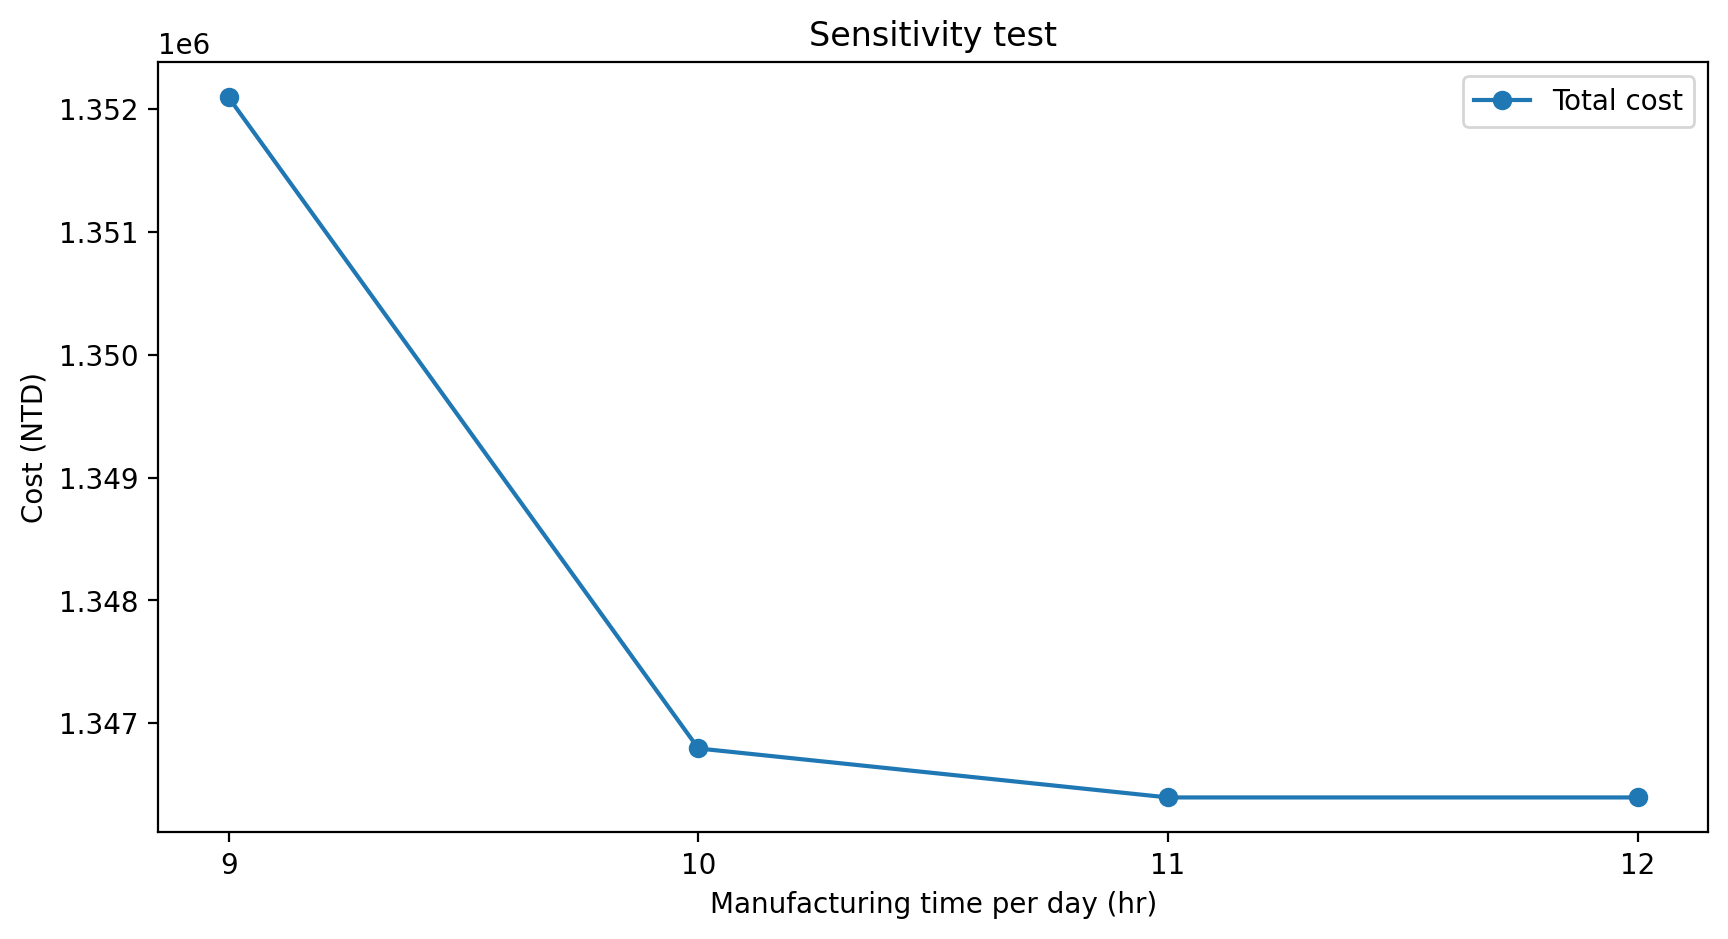

In [5]:
import matplotlib.pyplot as plt

# Manufacturing time per day
hr = [i for i in range(9, 13)]


# Choose the important feature to plot figures
plt.figure(figsize=(10, 5), dpi=200)

plt.plot(hr, Total_cost, marker="o", label="Total cost")
# plt.plot(hr, Production_cost, marker='v', label='Production cost')
# plt.plot(hr, Setup_cost, marker='s', label='Setup cost')
# plt.plot(hr, Over_time_production_cost, marker='x', label='Over time production cost')
# plt.plot(hr, Over_time_personnel_cost, marker='.', label='Over time personnel cost')

plt.xticks(hr)
plt.title("Sensitivity test")
plt.xlabel("Manufacturing time per day (hr)")
plt.ylabel("Cost (NTD)")
plt.legend()

plt.show()
plt.close()